In [89]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import re
from gensim import corpora, models
from openai import OpenAI

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
df = pd.read_csv('Reviews.csv')

In [53]:
# EDA: Explore the dataset
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [54]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# Topic Modeling
# dictionary = corpora.Dictionary(df['processed_text'])
# corpus = [dictionary.doc2bow(text) for text in df['processed_text']]
# lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [55]:
def label_sentiment(row):
    if row['Score'] == 5:
        return 'positive'
    elif row['Score'] == 1:
        return 'negative'
    else:
        return 'neutral'  # Assuming other scores are neutral

# Apply the function to each row to create a new sentiment label column
df['SentimentLabel'] = df.apply(label_sentiment, axis=1)

In [57]:
def format_training_data(row):
    label = row['SentimentLabel']
    text = row["Text"]
    # Assuming labels are in a list format
    return f'__label__{label} {text}' 

In [58]:
# Apply the function to each row
df['training_data'] = df.apply(format_training_data, axis=1)

In [59]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentLabel,training_data
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,__label__positive I have bought several of the...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,__label__negative Product arrived labeled as J...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,neutral,__label__neutral This is a confection that has...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,neutral,__label__neutral If you are looking for the se...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,__label__positive Great taffy at a great price...


In [60]:
df_learn = df[(df['SentimentLabel']=='positive') | (df['SentimentLabel']=='negative')]

def write_training_data_to_file(lists, file_path):
    """
    Writes formatted training data to a file.
    :param df: The list containing the training data.
    :param file_path: Path of the file to write the training data.
    """
    with open(file_path, 'w', encoding='utf-8') as file:
        for line in lists:
            file.write(line+'\n')

In [106]:
df_learn['SentimentLabel'].value_counts()

SentimentLabel
positive    363122
negative     52268
Name: count, dtype: int64

# Text Clustering and Diversify
Diversify the training data by choosing text from different clusters and context

In [91]:
# Get the default English stopwords list from NLTK
stop_words = nltk.corpus.stopwords.words('english')
custom_stop_words = ['br', 've']
stop_words.extend(custom_stop_words)

In [98]:
stop_words[:9]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you']

In [95]:
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.5, min_df=1)
X = vectorizer.fit_transform(df_learn['Text'].apply(lambda x: x.lower()))

In [99]:
# Choose the number of clusters
num_clusters = 3  # Adjust based on your needs

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X)

# Add cluster information back to DataFrame
df_learn['cluster'] = clusters

C:\Users\phant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\phant\AppData\Local\Temp\ipykernel_21000\168954089.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_learn['cluster'] = clusters


In [100]:
# Example: Print top terms per cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Top 10 terms
    print(", ".join(top_terms))

Top terms per cluster:
Cluster 0:
great, like, product, good, love, food, one, taste, flavor, amazon
Cluster 1:
tea, green, teas, drink, flavor, like, great, love, good, taste
Cluster 2:
coffee, cup, strong, like, flavor, cups, great, bold, taste, good


In [103]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

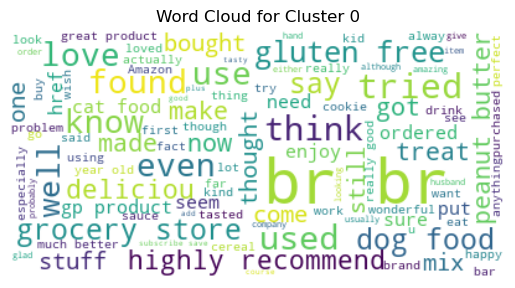

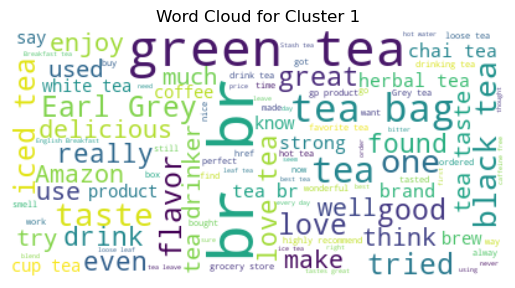

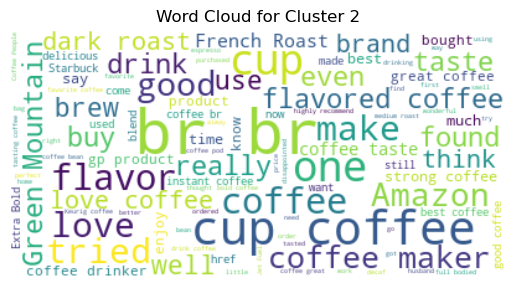

In [105]:
# Create a WordCloud for each cluster
for i in range(num_clusters):
    # Extract all reviews in cluster i and remove stopwords
    cluster_reviews = df_learn[df_learn['cluster'] == i]['Text'].apply(remove_stopwords)
    # Combine all reviews into a single string
    combined_text = " ".join(cluster_reviews)
    # Generate a word cloud image
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(combined_text)
    
    # Display the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {i}")
    plt.show()

In [69]:
# train_samples = samples[:int(len(samples)*0.8)]
# val_samples = samples[int(len(samples)*0.8):]
# Parameters
train_proportion = 0.8

# Splitting each cluster
train_samples = []
val_samples = []

for cluster in np.unique(df_learn['cluster']):
    # Get indices of samples in this cluster
    cluster_indices = df_learn[df_learn['cluster'] == cluster].index
    
    # Determine the split index
    split_idx = int(len(cluster_indices) * train_proportion)
    
    # Split indices into training and validation
    train_indices = cluster_indices[:split_idx]
    val_indices = cluster_indices[split_idx:]

    # Append the corresponding training data
    train_samples.extend(df_learn.loc[train_indices, 'training_data'].tolist())
    val_samples.extend(df_learn.loc[val_indices, 'training_data'].tolist())

In [71]:
print(len(train_samples))
print(len(val_samples))

332309
83081


In [72]:
write_training_data_to_file(train_samples,"amz_train_samples")
write_training_data_to_file(val_samples,"amz_val_samples")

In [80]:
train_samples[:5]

['__label__negative Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
 '__label__positive Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.',
 "__label__positive This saltwater taffy had great flavors and was very soft and chewy.  Each candy was individually wrapped well.  None of the candies were stuck together, which did happen in the expensive version, Fralinger's.  Would highly recommend this candy!  I served it at a beach-themed party and everyone loved it!",
 '__label__positive This taffy is so good.  It is very soft and chewy.  The flavors are amazing.  I would definitely recommend you buying it.  Very satisfying!!',
 "__label__positive Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheat

In [81]:
val_samples[:5]

['__label__positive I have been drinking Essentia Water for the past year after a friend introduced me to Ph correct alkaline water. I used to take gallons from her ionic filter, but after a while I needed to find a new source. Another friend sent a list of alkaline waters in which Essentia was one of them. I have been hooked ever since. Not only is it one of the highest Ph waters avaiable, it is highly hydrating so you get more hydration for your gulps. But it also tastes really good and quenches the thirst thoroughly! A case lasts me about a month, so it is also cost-efficient. Now that it is sold through Amazon, the shipping is free. Great water, great price, and you feel great after drinking it!',
 "__label__positive I have to give them credit for how smooth the taste of this is. They did a good job purifying it ahead of time. It didn't have any lingering chlorine taste or anything like it that I detected.<br /><br />It is obviously more impractical and expensive to buy bottles of 

In [82]:
model = fasttext.train_supervised(input='amz_train_samples')

In [83]:
model.save_model("model_text.bin")

In [84]:
model.test("amz_val_samples")

(83081, 0.9656479820897678, 0.9656479820897678)

In [76]:
# Assigning the precision and recall values from the test result
test_result = model.test("amz_val_samples")
_, precision, recall = test_result

# Calculating F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'F1-score of the model: {f1_score}')

F1-score of the model: 0.9654072531625763


In [35]:
for text in df["Text"].head(6):
    prediction = model.predict(text)
    print(f'Text: {text} \n Prediction: {prediction}')

Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. 
 Prediction: (('__label__positive',), array([0.99152106]))
Text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo". 
 Prediction: (('__label__negative',), array([0.99532932]))
Text: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wa

In [122]:
result= model.predict('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.')

In [137]:
def get_sentiment(text):
    # Get the model's prediction for the text
    prediction = model.predict(text)
    # Extract the probability
    probability = prediction[1][0]
    sentiment = 1 if prediction[0][0] == '__label__positive' else -1
    return probability*sentiment

In [150]:
# Apply the function to each row in the 'Text' column of the DataFrame
df['predicted_probability'] = df['Text'].apply(get_sentiment)
#df['Text'].tail(50).apply(get_predicted_probability)

In [151]:
# Group by 'Score' and calculate the mean of 'predicted_probability' for each group
average_probabilities = df.groupby('Score')['predicted_probability'].mean().reset_index()

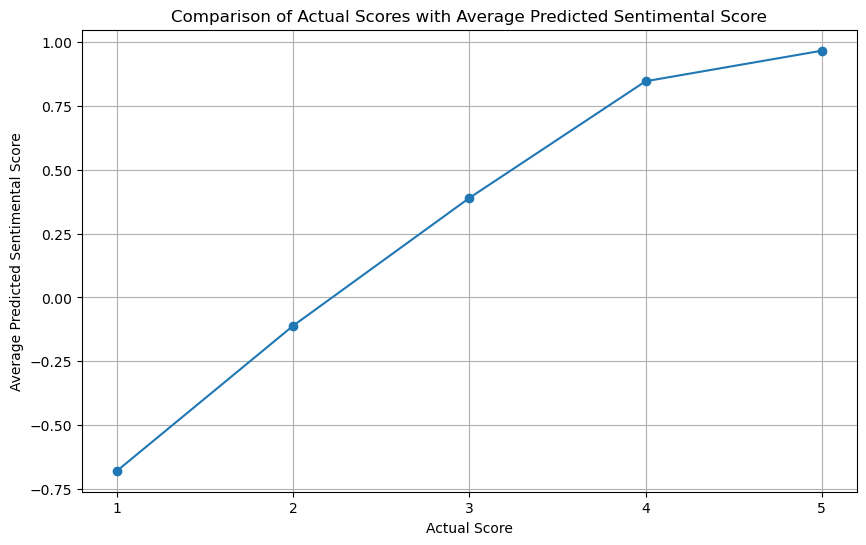

In [152]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_probabilities['Score'], average_probabilities['predicted_probability'], marker='o')
plt.xlabel('Actual Score')
plt.ylabel('Average Predicted Sentimental Score')
plt.title('Comparison of Actual Scores with Average Predicted Sentimental Score')
plt.xticks(average_probabilities['Score'])  # Set x-ticks to be actual scores
plt.grid(True)
plt.show()


In [121]:
df['predicted_probability'] = df['Text'].apply(get_predicted_probability)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentLabel,training_data,predicted_probability
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative,__label__negative Product arrived labeled as J...,0.994938
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,negative,__label__negative My cats have been happily ea...,0.543538
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",negative,"__label__negative The candy is just red , No f...",0.959289
50,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,1,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",negative,__label__negative This oatmeal is not good. It...,0.980317
62,63,B001EO5TPM,A1E09XGZUR78C6,gary sturrock,2,2,1,1215302400,stale product.,Arrived in 6 days and were so stale i could no...,negative,__label__negative Arrived in 6 days and were s...,0.980147
73,74,B0059WXJKM,A25VFHVGI4CFTP,Diana Robinson,0,1,1,1335744000,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...,negative,__label__negative Buyer Beware Please! This sw...,0.959802
75,76,B001EPPI84,A27TZ4WBU7N0YF,I. So,0,0,1,1275004800,No Tea Flavor,No tea flavor at all. Just whole brunch of art...,negative,__label__negative No tea flavor at all. Just w...,0.999409
99,100,B0019CW0HE,A2P6ACFZ8FTNVV,Melissa Benjamin,0,1,1,1331164800,Bad,I fed this to my Golden Retriever and he hated...,negative,__label__negative I fed this to my Golden Retr...,0.999900
153,154,B002HQAXUW,A17ESTP5T7T1PH,Bumbeda1,1,1,1,1324944000,Rip off Price,These singles sell for $2.50 - $3.36 at the st...,negative,__label__negative These singles sell for $2.50...,0.833179
164,165,B000ITVLE2,ARTBQH9WOZTIV,"Billy Wilson ""amzrview""",0,4,1,1269216000,Tasteless but low calorie,Seriously this product was as tasteless as the...,negative,__label__negative Seriously this product was a...,0.943637
